# Regresión Logística

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oramosul/abd-files/blob/main/spark/3-spark-mllib/3-Clasificacion-RegLogistica.ipynb)

In [ ]:
# Solo si se corre en Google Colab
!pip install -q pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression

spark = SparkSession.builder.getOrCreate()

In [ ]:
# Carga de archivos
!wget -q https://raw.githubusercontent.com/oramosul/abd-files/main/spark/datos/titanic.csv

## 1. Lectura de Datos

Se utilizará los datos del Titanic. Estos datos tienen la siguiente estructura:
* Sobrevive: 0 = No, 1 = Sí
* Clase: clase del pasajero (1 = 1a, 2 = 2da, 3 = 3a)
* Genero
* Sibsp: Número de hermanos + esposo(a) a bordo
* Parch: Número de padres + hijos a bordo
* Boleto: Número de boleto
* Precio: Precio del boleto
* Cabina
* PuertoEmb: puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

In [ ]:
df = spark.read.csv('titanic.csv', inferSchema=True, header=True)

df.show(5)

+----------+---------+-----+--------------------+------+----+-----+-----+----------------+-------+------+---------+
|IDpasajero|Sobrevive|Clase|              Nombre|Genero|Edad|SibSp|ParCh|          Boleto| Precio|Cabina|PuertoEmb|
+----------+---------+-----+--------------------+------+----+-----+-----+----------------+-------+------+---------+
|         1|        0|    3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|  NULL|        S|
|         2|        1|    1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|   C85|        C|
|         3|        1|    3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|  NULL|        S|
|         4|        1|    1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|  C123|        S|
|         5|        0|    3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|  NULL|        S|
+----------+---------+-----+--------------------+------+----+-----+-----

In [ ]:
# Esquema
df.printSchema()

root
 |-- IDpasajero: integer (nullable = true)
 |-- Sobrevive: integer (nullable = true)
 |-- Clase: integer (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Edad: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- ParCh: integer (nullable = true)
 |-- Boleto: string (nullable = true)
 |-- Precio: double (nullable = true)
 |-- Cabina: string (nullable = true)
 |-- PuertoEmb: string (nullable = true)



## 2. Pre-procesamiento

Se desea predecir la variable `Sobrevive` usando las variables `Clase`, `Genero`, `Edad`, `SibSp`, `ParCh`, `Precio`, `PuertoEmb`. Por tanto, se reducirá el DataFrame a solo estas variables (columnas).

De manera arbitraria se eliminará los valores nulos (se puede realizar un mayor análisis de estos valores, pero aquí por facilidad se eliminará todas las filas que contengan algún nulo)

In [ ]:
# Seleccionar solo algunas columnas
df = df.select(['Clase', 'Genero', 'Edad', 'SibSp', 'ParCh', 'Precio', 'PuertoEmb',
                'Sobrevive'])

# Eliminar filas con datos faltantes
df = df.na.drop()

Se separará los datos en entrenamiento (train) y prueba o evaluación (test)

In [ ]:
# Separación de datos en entrenamiento (70%) y prueba (30%)
df_train, df_test = df.randomSplit([0.7,0.3])

# Mostrar algunos datos de entrenamiento
df_train.show(5)

+-----+------+----+-----+-----+--------+---------+---------+
|Clase|Genero|Edad|SibSp|ParCh|  Precio|PuertoEmb|Sobrevive|
+-----+------+----+-----+-----+--------+---------+---------+
|    1|female| 2.0|    1|    2|  151.55|        S|        0|
|    1|female|14.0|    1|    2|   120.0|        S|        1|
|    1|female|15.0|    0|    1|211.3375|        S|        1|
|    1|female|16.0|    0|    0|    86.5|        S|        1|
|    1|female|16.0|    0|    1|    39.4|        S|        1|
+-----+------+----+-----+-----+--------+---------+---------+
only showing top 5 rows



### Conversión de datos categóricos en one-hot encoding

Hay dos columnas con datos categóricos: `PuertoEmb` y `Genero`. Estas columnas serán convertidas en numéricas usando "One-Hot Encoding". Con este fin, primero se les asignará un valor o índice (a través de `StringIndexer`) y luego recién se aplicará `OneHotEncoder`.

Por ejemplo, para el puerto de embarque, que tiene 3 valores categóricos, la primera etapa asigna valores numéricos de la siguiente forma: $C=0$, $S=1$, $Q=2$. Luego one-hot encoding crea 3 nuevas columnas con un valor $1$ si corresponde a ese valor, o $0$ si no corresponde a ese valor.

| PuertoEmb | C | S | Q |
| --- | --- | --- | --- |
| C | 1 | 0 | 0 |
| S | 0 | 1 | 0 |
| Q | 0 | 0 | 1 |



In [ ]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [ ]:
# Asignación de índices a "género"
genero_indexer = StringIndexer(inputCol='Genero', outputCol='GeneroIndex')
# Conversión de cada índice en "one-hot encoding"
genero_onehot = OneHotEncoder(inputCol='GeneroIndex',outputCol='GeneroVec')

In [ ]:
# Conversión de valores de puerto en "índices" y luego en "one-hot encoding"
puerto_indexer = StringIndexer(inputCol='PuertoEmb',outputCol='PuertoIndex')
puerto_onehot = OneHotEncoder(inputCol='PuertoIndex',outputCol='PuertoVec')

La columna atributos, que necesita Spark MLlib, se generará utilizando las variables escogidas, pero reemplazando `Genero` y `PuertoEmb` por sus versiones con one-hot encoding.

In [ ]:
# Vector que agrupa todos los atributos
vassembler = VectorAssembler(inputCols=['Clase', 'GeneroVec', 'PuertoVec', 'Edad',
                                        'SibSp', 'ParCh', 'Precio'],
                             outputCol='atributos')

## 3. Creación de un pipeline y Entrenamiento

En este ejemplo se utilizará la regresión logística como clasificador.

In [ ]:
# Modelo de regresión logística
modelo_reglog = LogisticRegression(featuresCol='atributos', labelCol='Sobrevive',
                                   predictionCol='Prediccion')

Un pipeline genera etapas que serán aplicadas a todos los datos (como un flujo de operaciones). En este caso el pipeline contiene 6 operaciones que se realizan en forma consecutiva, de la siguiente manera:
* Conversión de `genero` en índice y luego en one-hot encoding
* Conversión de `puerto` en índice y luego en one-hot encoding
* Ensamble del vector de atributos
* Aplicación de los datos (y entrenamiento) al modelo de regresión logística

In [ ]:
from pyspark.ml import Pipeline

# Definición de las etapas (pipeline)
pipeline = Pipeline(stages=[genero_indexer, genero_onehot,
                            puerto_indexer, puerto_onehot,
                            vassembler, modelo_reglog])

In [ ]:
# Aplicación de los datos de entrenamiento al pipeline creado
modelo = pipeline.fit(df_train)

In [ ]:
# Etapas del modelo creado (usando el pipeline)
# modelo.stages

### Métricas para el entrenamiento

In [ ]:
# Recuperación del modelo de regresión logística
reglog = modelo.stages[5]
reglog

LogisticRegressionModel: uid=LogisticRegression_49e6baf29e44, numClasses=2, numFeatures=8

In [ ]:
# Predicciones para el conjunto de entrenamiento
reglog.summary.predictions.show(5)

+-----+------+----+-----+-----+--------+---------+---------+-----------+---------+-----------+-------------+--------------------+--------------------+--------------------+----------+
|Clase|Genero|Edad|SibSp|ParCh|  Precio|PuertoEmb|Sobrevive|GeneroIndex|GeneroVec|PuertoIndex|    PuertoVec|           atributos|       rawPrediction|         probability|Prediccion|
+-----+------+----+-----+-----+--------+---------+---------+-----------+---------+-----------+-------------+--------------------+--------------------+--------------------+----------+
|    1|female| 2.0|    1|    2|  151.55|        S|      0.0|        1.0|(1,[],[])|        0.0|(2,[0],[1.0])|[1.0,0.0,1.0,0.0,...|[-3.6322024678957...|[0.02577587349653...|       1.0|
|    1|female|14.0|    1|    2|   120.0|        S|      1.0|        1.0|(1,[],[])|        0.0|(2,[0],[1.0])|[1.0,0.0,1.0,0.0,...|[-3.0656129857119...|[0.04454818224425...|       1.0|
|    1|female|15.0|    0|    1|211.3375|        S|      1.0|        1.0|(1,[],[])|   

In [ ]:
# True Positives (por etiqueta)
print("TP para prueba:", reglog.summary.truePositiveRateByLabel)

TP para prueba: [0.8630573248407644, 0.7135678391959799]


In [ ]:
# False Positives (por etiqueta)
print("FP para prueba:", reglog.summary.falsePositiveRateByLabel)

FP para prueba: [0.2864321608040201, 0.13694267515923567]


In [ ]:
# Métricas para el conjunto de entrenamiento
accuracy = reglog.summary.accuracy
AUC = reglog.summary.areaUnderROC

print("Exactitud en el conjunto de entrenamiento:", accuracy)
print("Área bajo la curva ROC en el conjunto de entrenamiento:", AUC)

Exactitud en el conjunto de entrenamiento: 0.8050682261208577
Área bajo la curva ROC en el conjunto de entrenamiento: 0.869234708574721


Curva ROC usando Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Curva ROC
roc = reglog.summary.roc.collect()
# Ejemplo de salidas
roc[0:2]

[Row(FPR=0.0, TPR=0.0), Row(FPR=0.0, TPR=0.005025125628140704)]

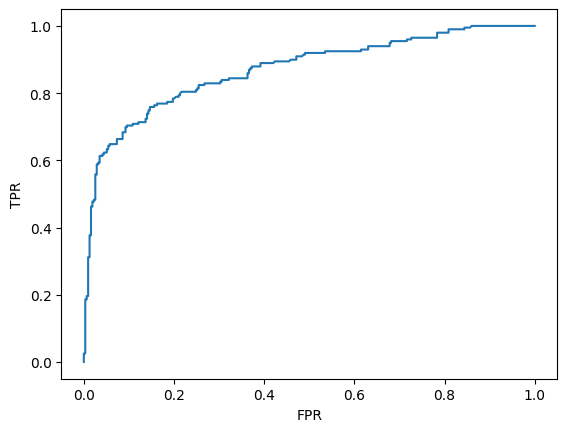

In [ ]:
n = len(roc); FPR = np.zeros(n); TPR = np.zeros(n)
for idx, elem in enumerate(roc):
  FPR[idx] = elem.FPR
  TPR[idx] = elem.TPR
plt.plot(FPR, TPR)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

## 4. Predicción y Evaluación

In [ ]:
# Aplicar el modelo a los datos de prueba (test)
resultado = modelo.transform(df_test)

# Resultados
resultado.select('Sobrevive','Prediccion').show(8)

+---------+----------+
|Sobrevive|Prediccion|
+---------+----------+
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
+---------+----------+
only showing top 8 rows



In [ ]:
# type(resultado)

In [ ]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator)

In [ ]:
evaluador1 = BinaryClassificationEvaluator(rawPredictionCol='Prediccion',
                                           labelCol='Sobrevive',
                                           metricName='areaUnderROC')
AUC = evaluador1.evaluate(resultado)
print("Área bajo la curva ROC en el conjunto de prueba:", AUC)

Área bajo la curva ROC en el conjunto de prueba: 0.7654239019407559


In [ ]:
# Evaluador de la exactitud (accuracy)
evaluador2 = MulticlassClassificationEvaluator(predictionCol='Prediccion',
                                               labelCol='Sobrevive',
                                               metricName='accuracy')
exactitud = evaluador2.evaluate(resultado)
print("Exactitud en el conjunto de prueba:", exactitud)

Exactitud en el conjunto de prueba: 0.7738693467336684
